In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import itertools
from scipy import stats
from scipy.spatial.distance import pdist, squareform 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib
from IPython.display import HTML, display
from sklearn.decomposition import NMF

In [6]:
df = pd.read_json('../data/lyrics_cleaned.json')

In [7]:
df.reset_index(drop=True, inplace=True)

In [23]:
# let's check out a random song
idx = np.random.randint(0,6252)
print(df.iloc[idx, 0], '-', df.iloc[idx, 1], '\n', 
      '--------------',
      '\n', df.iloc[idx, 2])

Rob Thomas - Her Diamonds 
 -------------- 
 Oh what the hell she said  I just can't win for losing  And she lays back down   Man there's so many times  I don't know what I'm doing  Like I don't know now    By the light of the moon  She rubs her eyes  Says it's funny how the night  Can make you blind  I can just imagine  And I don't know what I'm supposed to do  But if she feels bad then i do too  So I let her be    And she says oh  I can't take no more  Her tears like diamonds on the floor  And her diamonds bring me down  Cause I can't help her now  She's down in it  She tried her best but now she can't win it  Hard to see them on the ground  Her diamonds falling down    She sits down and stares into the distance  And it takes all night  And i know i could break her concentration  But it don't feel right    By the light of the moon  She rubs her eyes  Sits down on the bed and starts to cry  And there's something less about her  And I don't know what I'm supposed to do  So I sit down a

In [ ]:
# def remove_accents(input_str):
#     nfkd_form = unicodedata.normalize('NFKD', input_str)
#     only_ascii = nfkd_form.encode('ASCII', 'ignore')
#     return only_ascii.decode()

# for song in lyrics_arr:
#     song = remove_accents(song)

In [46]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [47]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\n3) top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))


3) top features (words) for each cluster:
0: don, baby, know, wanna, just, want, ll, like, let, girl
1: like, just, ll, ve, yeah, know, got, love, time, don
2: like, nigga, got, yeah, bitch, ain, shit, fuck, ya, niggas
3: oh, yeah, baby, like, know, love, don, want, let, ooh
4: love, baby, know, ll, don, heart, just, way, need, like
5: la, love, like, baby, don, lala, oh, just, ooh, cause


**Not really useful outputs. Contractions are being split and shouldn't be. Too many words are common across all found topics. Need to adjust the stopwords a bit. Might find some value in increasing n-grams.**

In [53]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=5000, 
                             ngram_range=(1,3))
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [64]:
top_idxs = np.argsort(vectorizer.idf_)[::-1]
bottom_idxs = np.argsort(vectorizer.idf_)[::]

In [65]:
features = vectorizer.get_feature_names()

In [72]:
bottom_100_words = [features[i] for i in bottom_idxs[:100]]

In [73]:
bottom_100_words

['know',
 'just',
 'like',
 'don',
 'got',
 'love',
 'll',
 'cause',
 'let',
 'time',
 'yeah',
 'baby',
 'make',
 'say',
 'oh',
 'way',
 'right',
 'want',
 'ain',
 'come',
 'wanna',
 've',
 'girl',
 'tell',
 'need',
 'feel',
 'think',
 'life',
 'night',
 'man',
 'good',
 'gonna',
 'look',
 'heart',
 'said',
 'day',
 'little',
 'gotta',
 'world',
 'away',
 'won',
 'mind',
 'chorus',
 'eyes',
 'ya',
 'long',
 'things',
 'thing',
 'better',
 'really',
 'hold',
 'home',
 'leave',
 'real',
 'shit',
 'stop',
 'don know',
 'em',
 'head',
 'turn',
 'hard',
 'hit',
 'stay',
 'boy',
 'hey',
 'new',
 'money',
 'bout',
 'did',
 'try',
 'gone',
 'hear',
 'left',
 'face',
 'play',
 'nigga',
 'tonight',
 'big',
 'fuck',
 'believe',
 'thought',
 'bad',
 'told',
 'run',
 'talk',
 'wrong',
 'gon',
 'live',
 'high',
 'going',
 'bitch',
 'inside',
 'crazy',
 'old',
 'yo',
 'break',
 'hand',
 'came',
 'feeling',
 'walk']

In [75]:
from nltk.corpus import stopwords
lyric_stopwords = set(stopwords.words('english') + bottom_100_words)

In [82]:
vectorizer = TfidfVectorizer(stop_words=list(lyric_stopwords), 
                             max_features=5000, 
                             ngram_range=(2,10))
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [77]:
def fit_nmf(r, data):
    nmf = NMF(n_components=r)
    nmf.fit(data)
    W = nmf.transform(data)
    H = nmf.components_
    return nmf.reconstruction_err_

Text(0, 0.5, 'Reconstruction Errror')

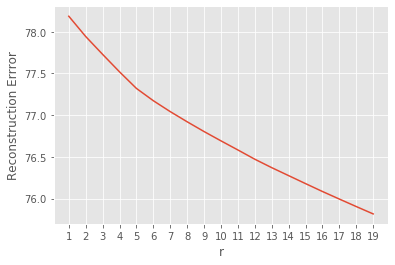

In [83]:
range_size = range(1, 20)
error = [fit_nmf(i, X) for i in range_size]
plt.plot(range_size, error)
plt.xticks(range_size)
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

Starting to see an elbow at n_components=5 with n_grams ranging from 2-10. But the reconstruction error is still really high.

**Try just looking at few artists at first**

In [ ]:
df.groupby('artist').count().sort_values(by='title', ascending=False).head(20)

In [ ]:
Em_Be_Ch = df[(df['artist'] == 'Eminem') | (df['artist'] == 'Kenny Chesney')]

In [ ]:
Em_Be_Ch

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(Em_Be_Ch['lyrics'])
features = vectorizer.get_feature_names()

max_r = 30
error = [fit_nmf(i, X) for i in range(1,max_r)]
plt.plot(range(1,max_r), error)
plt.xticks(range(1, max_r))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

## Let's build a vectorizer from scratch!

In [ ]:
def lyric_tokenizer():
    

In [43]:
from nltk.util import ngrams
from nl
def get_word_list(text):
    result = text.lower().split()
    # square brackets signify who is speaking/singing
    result = [w for w in result if (w.startswith('[') and w.endswith(']')) != True]
    
    return result

In [44]:
# text = df.iloc[np.random.randint(0,6252), 2]

In [45]:
get_word_list(text)

['uh',
 'huh',
 'yea,',
 'yeah',
 'duro!',
 'you',
 'gotta',
 'let',
 'it',
 'bump',
 'uh,',
 'uh,',
 'uh',
 'like',
 'dat',
 'yeah',
 'come',
 'on',
 'bring',
 'the',
 'chorus',
 'in',
 '1',
 '-',
 "i'd",
 'risk',
 'everything',
 'for',
 'one',
 'kiss,',
 'everything',
 'yes',
 "i'd",
 'do',
 'anything',
 '(anything?)',
 'anything',
 'for',
 'you',
 "i'd",
 'do',
 'a',
 'bid,',
 'loose',
 'a',
 'rib,',
 'bust',
 'a',
 'cap,',
 "trustin'",
 'that',
 'run',
 'up',
 'to',
 'heaven',
 'doors,',
 'exchange',
 'my',
 'life',
 'for',
 'yours',
 'leave',
 'a',
 'steak',
 'out',
 'the',
 'door,',
 'mi',
 'casa,',
 'su',
 'casa',
 'just',
 'remember',
 'to',
 'turn',
 'the',
 'lights',
 'off',
 'in',
 'the',
 'hall',
 'my',
 'brother',
 'from',
 'anotha',
 'pop,',
 'minus',
 'one',
 'shot',
 'we',
 'neno',
 'and',
 'g-money',
 'man,',
 'we',
 'all',
 'we',
 'got',
 'from',
 'the',
 'stoop',
 'to',
 'the',
 'big',
 'dudes,',
 "stoppin'",
 'us',
 'from',
 "playin'",
 'hoops',
 'and',
 'us',
 'get